In [1]:
import re
import folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from konlpy.tag import Okt
okt = Okt()

In [2]:
df = pd.read_csv('job_data.csv')

In [3]:
df.columns

Index(['직무명', '회사명', '위치', '경력', '주요업무', '자격요건', '우대사항'], dtype='object')

# 위치

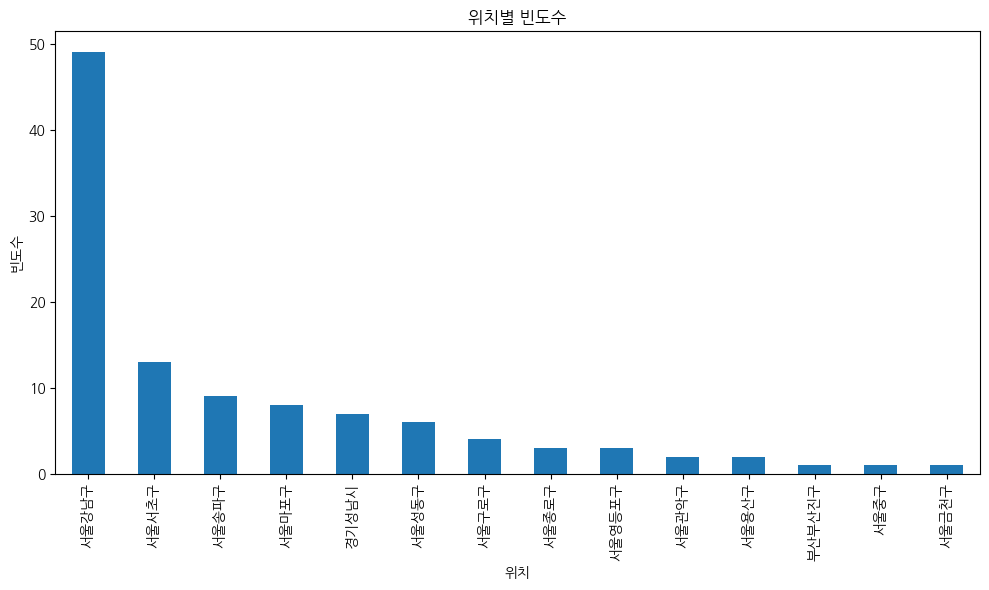

In [4]:
df['위치'] = df['위치'].str.replace(" ", "")
location_counts = df['위치'].value_counts()

plt.rcParams["font.family"] = 'NanumGothic'
plt.figure(figsize=(10, 6))
location_counts.sort_values(ascending=False).plot(kind='bar')
plt.title('위치별 빈도수')
plt.xlabel('위치')
plt.ylabel('빈도수')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [5]:
location_data = {
    "서울강남구": [37.5172363, 127.0473248],
    "서울서초구": [37.483576, 127.0326612],
    "서울송파구": [37.514543, 127.1059686],
    "서울마포구": [37.5663245, 126.901636],
    "경기성남시": [37.420065, 127.126822],
    "서울성동구": [37.563341, 127.036419],
    "서울구로구": [37.4954856, 126.8877122],
    "서울종로구": [37.573275, 126.979358],
    "서울영등포구": [37.526342, 126.896016],
    "서울관악구": [37.478406, 126.951613],
    "서울용산구": [37.532303, 126.990836],
    "부산부산진구": [35.162437, 129.055113],
    "서울중구": [37.557945, 126.994190],
    "서울금천구": [37.456872, 126.895200]
}

df = pd.read_csv('job_data.csv')
df['위치'] = df['위치'].str.replace(" ", "")
location_counts = df['위치'].value_counts()

m = folium.Map(location=[35.1796, 129.0756], zoom_start=7)

for location, count in location_counts.items():
    if location in location_data:
        lat, lon = location_data[location]
        
        folium.CircleMarker(
            location=[lat, lon],
            radius=count * 2,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6,
            tooltip=f"{location}: {count}개"
        ).add_to(m)

        folium.map.Marker(
            [lat, lon],
            icon=folium.DivIcon(html=f"""
                <div style="font-size: 12pt; color: black; text-align: center; white-space: nowrap;">
                    {location}: {count}개
                </div>""")
        ).add_to(m)

m.save("./app/location_map.html")
"""
uvicorn main:app --host 0.0.0.0 --port 5000
"""

'\nuvicorn main:app --host 0.0.0.0 --port 5000\n'

# 경력

In [6]:
def preprocess_career(text):
    text = re.sub(r'신입', '1', str(text))
    text = re.sub(r'[^0-9-]', '', text)
    text = text.strip().strip('-')

    return text

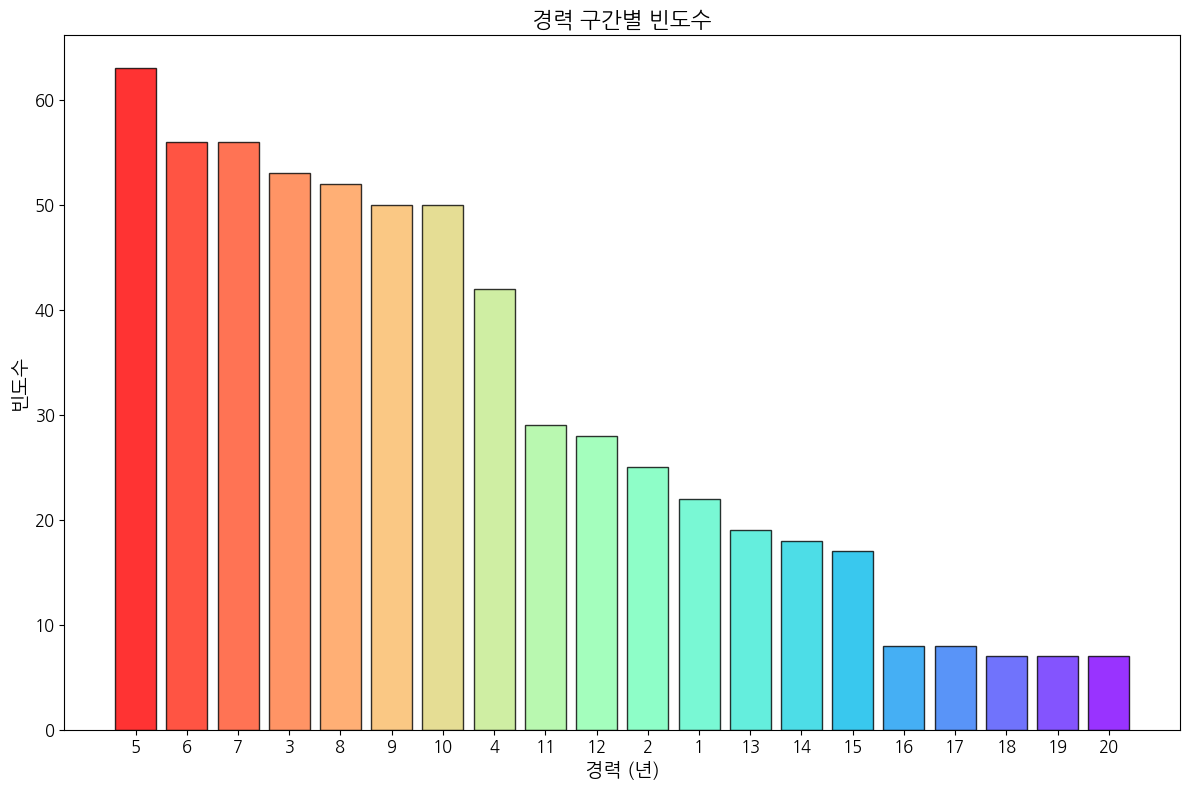

In [7]:
preprocessed_career = df['경력'].apply(preprocess_career)

experience_list = []
for experience in preprocessed_career:
    if experience:
        if '-' in experience:
            start, end = experience.split('-')
            experience_list.extend(range(int(start), int(end) + 1))
        else:
            experience_list.append(int(experience))

experience_counts = pd.Series(experience_list).value_counts().sort_values(ascending=False)

colors = plt.cm.rainbow(np.linspace(1, 0, len(experience_counts)))

plt.rcParams["font.family"] = 'NanumGothic'
plt.figure(figsize=(12, 8))
plt.bar(
    experience_counts.index.astype(str),
    experience_counts.values,
    color=colors,
    edgecolor="black",
    alpha=0.8
)
plt.title('경력 구간별 빈도수', fontsize=16)
plt.xlabel('경력 (년)', fontsize=14)
plt.ylabel('빈도수', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [8]:
class TextPreProcessing:
    def __init__(self, df, stopwords=[], keep_phrases=None):
        self.df = df.copy()
        self.stopwords = stopwords
        self.keep_phrases = keep_phrases

    def clean_text(self, text):
        return re.sub(r'[^가-힣\s]', '', text) # 영어, 숫자, 특수문자 제거
    
    def remove_konlpy_stopwords(self, text):
        words = okt.pos(text, norm=True, stem=True)  # 어간 추출로 기본형으로 변환
        if self.keep_phrases is None:
            self.keep_phrases = []
        
        # 형태소 분석 결과를 바탕으로 문장 구성
        processed_words = []
        skip = False
        for i, (word, pos) in enumerate(words):
            if skip:
                skip = False
                continue
            # 지정된 결합 단어가 있을 경우 결합하여 유지
            if i < len(words) - 1 and f"{word}{words[i+1][0]}" in self.keep_phrases:
                processed_words.append(f"{word}{words[i+1][0]}")
                skip = True
            elif pos not in ['Josa', 'Eomi', 'Punctuation']:
                processed_words.append(word)
        
        return ' '.join(processed_words)
    
    def remove_custom_stopwords(self, text):
        if self.stopwords is not None:
            words = text.split()
            return ' '.join([word for word in words if word not in self.stopwords])

        else:
            return text

    def remove_final_da(self, text):
        words = text.split()
        return ' '.join([word for word in words if not word.endswith('다')])
    
    def preprocessing(self, file_path=None):
        cleaned_text_with_stopwords_removed = '\n'.join([
            self.remove_custom_stopwords(
                self.remove_final_da(
                    self.remove_konlpy_stopwords(
                        self.clean_text(text)
                    )
                ),
            )
            for text in self.df
        ])

        if file_path:
            with open(file_path, 'w') as file:
                file.write(cleaned_text_with_stopwords_removed)

        return cleaned_text_with_stopwords_removed

In [9]:
def generate_circular_wordcloud(word_frequencies, font_path='NanumGothic.ttf', width=300, height=300, circle_radius=140):
    x, y = np.ogrid[:height, :width]
    mask = (x - width // 2) ** 2 + (y - height // 2) ** 2 > circle_radius ** 2
    mask = 255 * mask.astype(int)

    def red_color_func(*args, **kwargs):
        return (0, 0, 255)

    wordcloud = WordCloud(
        font_path=font_path,
        width=width, height=height,
        background_color='white',
        mask=mask,
        color_func=red_color_func
    ).generate_from_frequencies(word_frequencies)

    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [10]:
def plot_word_frequencies(word_list, word_counts, title="상위 20개 단어 빈도수", width=0.6):
    colors = plt.cm.rainbow(np.linspace(1, 0, len(word_list)))

    plt.figure(figsize=(12, 8))
    bars = plt.bar(word_list, word_counts, color=colors, width=width)

    plt.title(title)
    plt.xlabel("단어")
    plt.xticks(rotation=0)
    plt.ylabel("빈도수")
    plt.show()

# 주요업무

In [11]:
stopwords = ['주요', '업무', "기반", "수", '및', '위', '등', '적', '통해', '들', '화']
keep_phrases = ["통계적"]

main_job_text_preprocessing = TextPreProcessing(df['주요업무'], stopwords, keep_phrases)
main_job_preprocessed_text = main_job_text_preprocessing.preprocessing()

main_job_words = main_job_preprocessed_text.split()
main_job_word_counts = Counter(main_job_words)

main_job_top_20_words = main_job_word_counts.most_common(20)
main_job_words, main_job_counts = zip(*main_job_top_20_words)

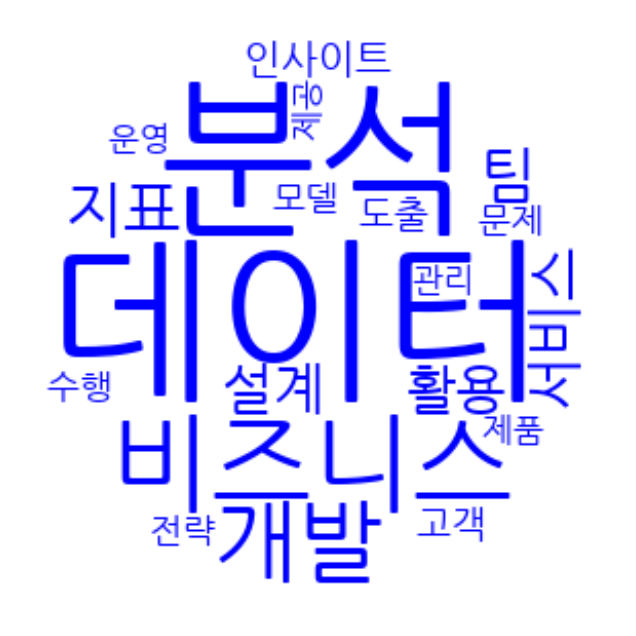

In [12]:
generate_circular_wordcloud(dict(main_job_top_20_words))

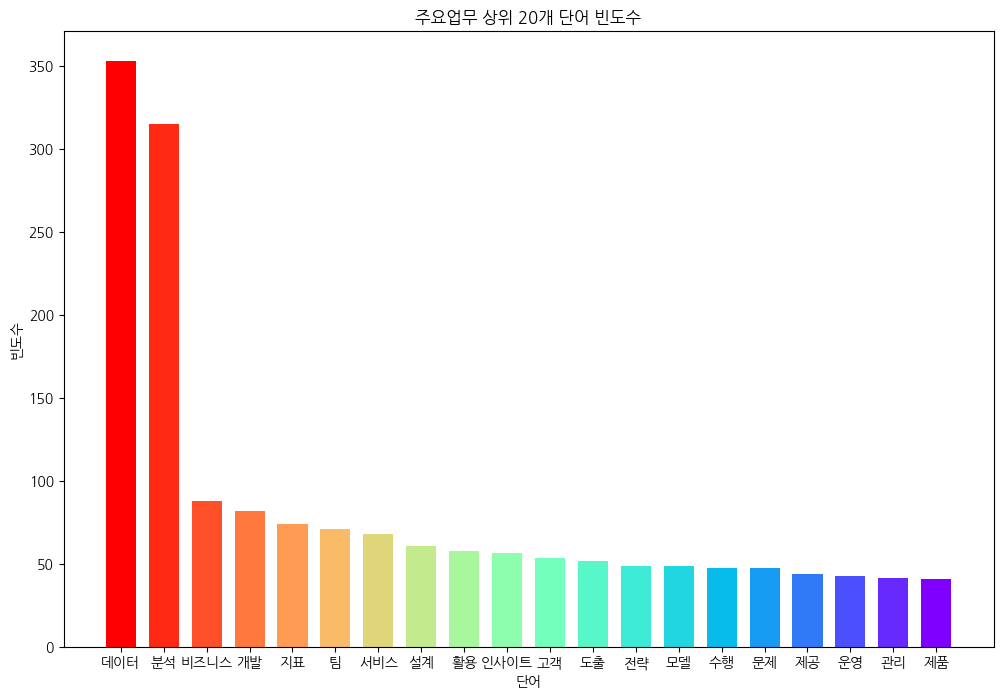

In [13]:
plot_word_frequencies(main_job_words, main_job_counts, "주요업무 상위 20개 단어 빈도수", 0.7)

# 자격요건

In [14]:
stopwords = ['자격', '요건', "기반", "수", '및', '위', '등', '적', '통해', '들', '화', '분', '년', '이상', '대한', '경력', '관련', '또는', '문제', '데이터', '분석']

check_list_text_preprocessing = TextPreProcessing(df['자격요건'], stopwords, keep_phrases=None)
check_list_preprocessed_text = check_list_text_preprocessing.preprocessing()

check_list_words = check_list_preprocessed_text.split()
check_list_word_counts = Counter(check_list_words)

check_list_top_20_words = check_list_word_counts.most_common(20)
check_list_words, check_list_counts = zip(*check_list_top_20_words)

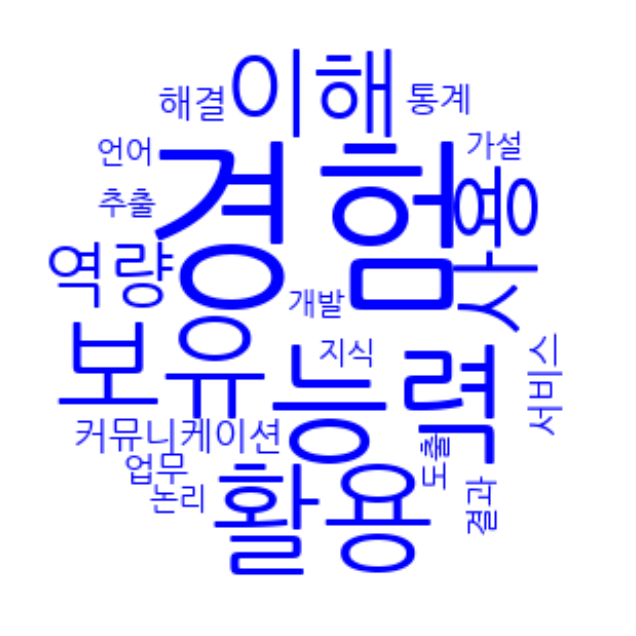

In [15]:
generate_circular_wordcloud(dict(check_list_top_20_words))

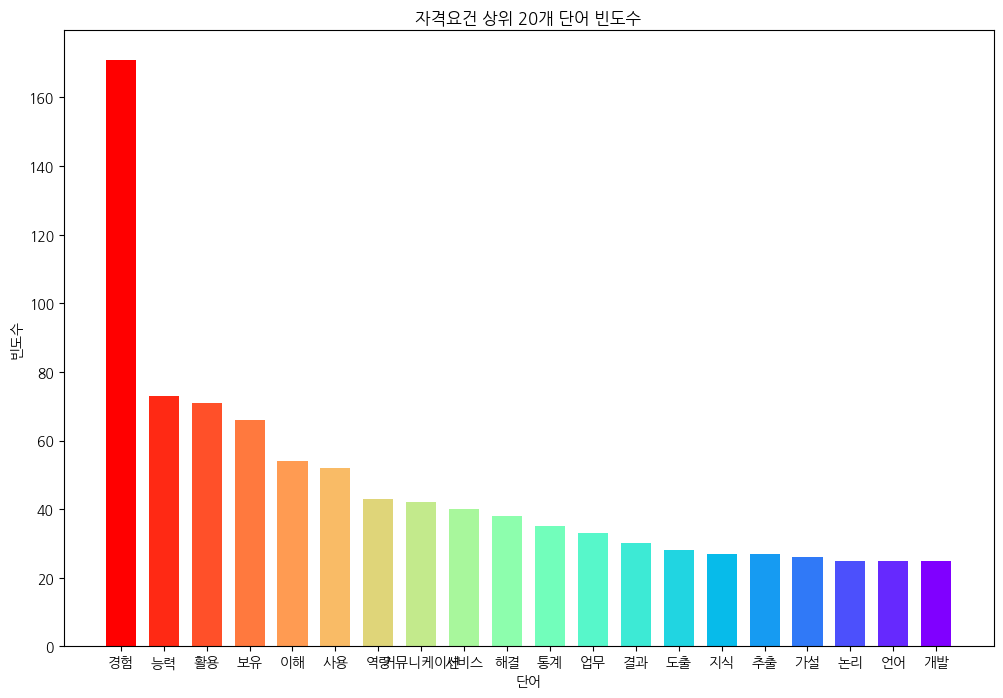

In [16]:
plot_word_frequencies(check_list_words, check_list_counts, "자격요건 상위 20개 단어 빈도수", 0.7)

# 우대사항

In [22]:
stopwords = ['우대', '사항', "기반", "수", '및', '위', '등', '적', '통해', '들', '화', '분', '년', '이상', '대한', '경력', '관련', '또는', '문제', '데이터', '분석', '자', '작성']
keep_phrases = ['머신러닝']
good_list_text_preprocessing = TextPreProcessing(df['우대사항'], stopwords, keep_phrases)
good_list_preprocessed_text = good_list_text_preprocessing.preprocessing()

good_list_words = good_list_preprocessed_text.split()
good_list_word_counts = Counter(good_list_words)

good_list_top_20_words = good_list_word_counts.most_common(20)
good_list_words, good_list_counts = zip(*good_list_top_20_words)

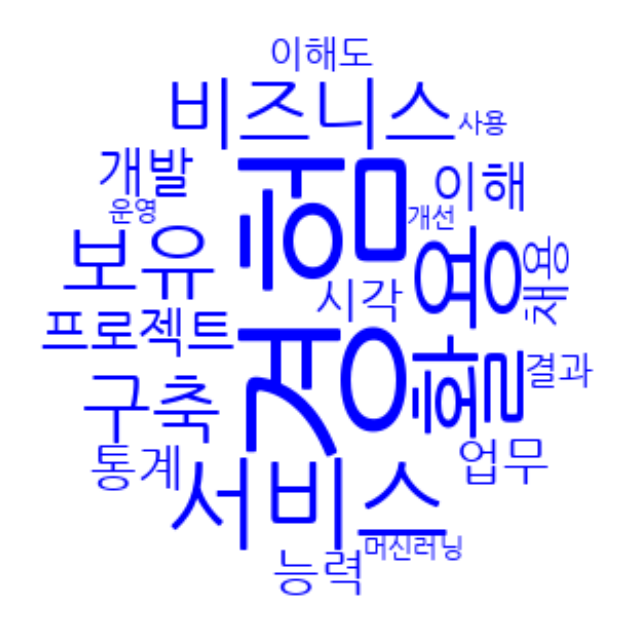

In [23]:
generate_circular_wordcloud(dict(good_list_top_20_words))

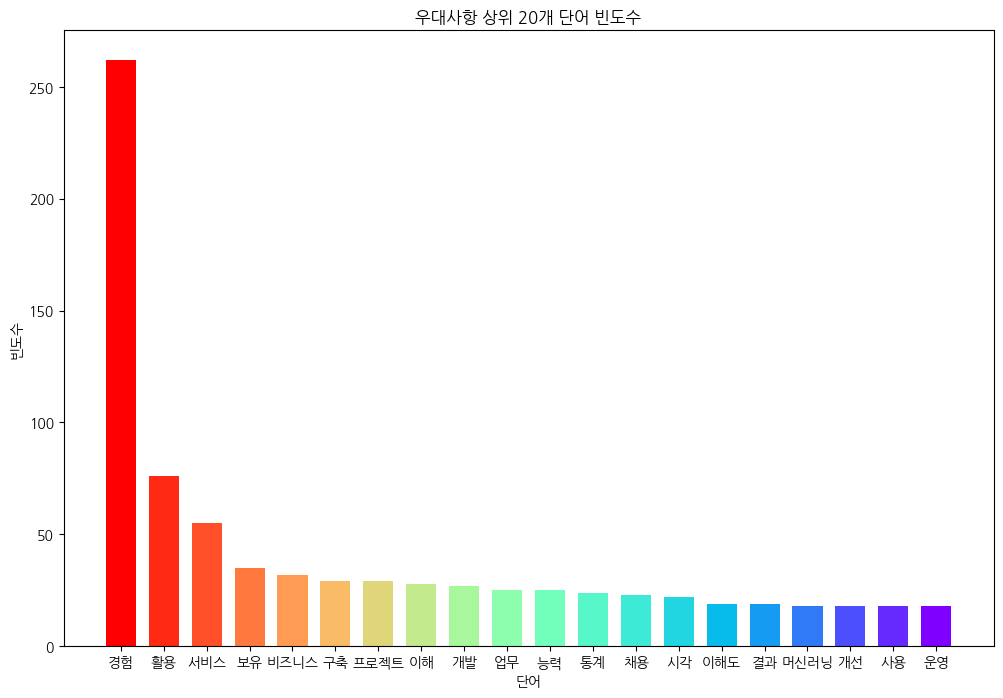

In [24]:
plot_word_frequencies(good_list_words, good_list_counts, "우대사항 상위 20개 단어 빈도수", 0.7)